In [1]:
import torch
from transformers import AdamW
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
model = GPT2Model.from_pretrained('gpt2-xl')

## Plotting sparsicity

### Flattening weights for each layer

In [5]:
i = 0
d = {}
KEYS=[]
for i in range(48):
  key = "h.{}.".format(i)
  d[key]=[]
  KEYS.append(key)

for name, param in model.named_parameters():
  a = (torch.flatten(param)).tolist()
  sub_4 = name[0:4]
  sub_5 = name[0:5] 
  if sub_4 in KEYS:
    d[sub_4].extend(a)
  elif sub_5 in KEYS:
    d[sub_5].extend(a)

### Plotting percentages

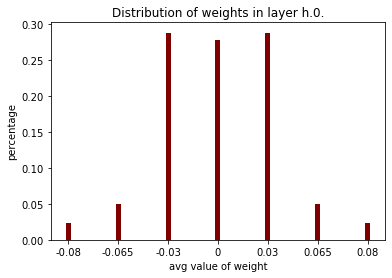

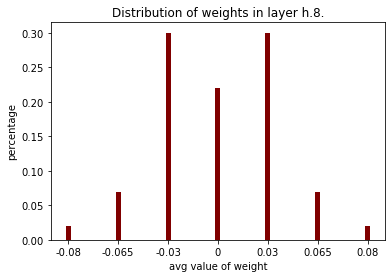

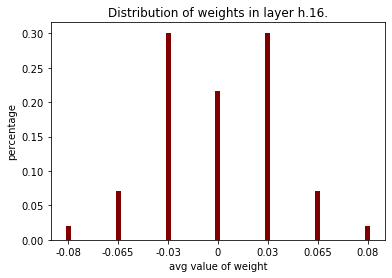

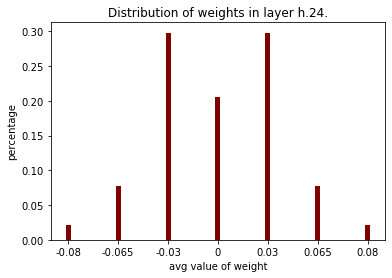

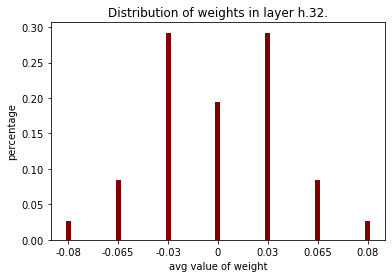

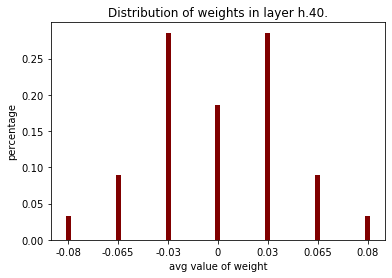

In [6]:
#for key, val in d.items()
import matplotlib.pyplot as plt

i = 0
for key, val in d.items():
    if i%8 != 0:
        i+=1
        continue
    a = val
    to_plot_dict = {}
    to_plot_dict['-0.08'] = 0
    to_plot_dict['-0.065'] = 0
    to_plot_dict['-0.03'] = 0
    to_plot_dict['0'] = 0
    to_plot_dict['0.03'] = 0
    to_plot_dict['0.065'] = 0
    to_plot_dict['0.08'] = 0
    


    for elem in a:
        if elem <= -.08:
            to_plot_dict['-0.08'] += 1
        elif elem <= -.05 and elem > -.08:
            to_plot_dict['-0.065'] += 1
        elif elem <= -.01 and elem > -0.05:
            to_plot_dict['-0.03'] += 1
        elif elem <= .01 and elem > -0.01:
            to_plot_dict['0'] += 1
        elif elem <= .05 and elem > 0.01:
            to_plot_dict['0.03'] += 1
        elif elem <= .08 and elem > 0.05:
            to_plot_dict['0.065'] += 1
        elif elem >= 0.08:
            to_plot_dict['0.08'] += 1

    x = list(to_plot_dict.keys())
    counts = list(to_plot_dict.values())
    y = [ind/len(a) for ind in counts]
    plt.figure()
    plt.bar(x, y, color ='maroon',
            width = 0.1)
    plt.xlabel("avg value of weight")
    plt.ylabel("percentage")
    plt.title("Distribution of weights in layer {}".format(key))
    plt.show()
    i+=1


### Plotting Density

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
i=0
for key, val in d.items():
    if i%8==0:
        plt.figure()
        plt.hist(val, density = True, bins = 1000, range= (-.25, .25))
        plt.gca().set(title='Density histogram for {}'.format(key), ylabel='Frequency')
        plt.show()
    i+=1

## Pruning the specified layers

In [12]:
def prune_layers(ratio):

    for i in range(48):
        list= ['h.{}.attn.c_attn'.format(i),
                'h.{}.attn.c_proj'.format(i),
                'h.{}.ln_1'.format(i),
                'h.{}.ln_2'.format(i),
                'h.{}.mlp.c_fc'.format(i),
                'h.{}.mlp.c_proj'.format(i)]
        for name, module in model.named_modules():
            if name in list:
                prune.l1_unstructured(module, name='weight', amount=ratio)
                prune.remove(module, 'weight')

model = GPT2Model.from_pretrained('gpt2-xl')
ratio = 0.2
prune_layers(ratio)

## Loading dataset

In [ ]:
from datasets import load_dataset
data_files = {"train": "train.csv", "test": "test.csv"}
dataset = load_dataset("lambada", data_files=data_files)